## SFINCS results: determine maximum water depth

This notebook contains 2 examples, one for a standard regular SFINCS model, and one for a subgrid SFINCS model.

IMPORTANT NOTE, the methods for producing a flood depth map for the regular vs subgrid versions of SFINCS are **NOT** the same, and **NOT** interchangeable!

Contents:
1. Determine maximum water depth for a regular model
2. Determine maximum water depth for a subgrid model


### 1. Determine maximum water depth for a regular model

The first example used in this notebook is based on a regular SFINCS model, i.e. no subgrid tables are used. In the absence of the subgrid tables, SFINCS computes the water depth by simply substracting the bed levels from the water levels. The (maximum) water depth **h(max)** is stored in the NetCDF output (*sfincs_map.nc*). 

How to derive maximum water depths for a model including subgrid tables is explained [later](#2.-Determine-maximum-water-depth-for-a-subgrid-model) in this notebook.

In [6]:
from os.path import join
import os
from pathlib import Path
import matplotlib.pyplot as plt
from hydromt_sfincs import SfincsModel, utils

### Read model results

The model results in sfincs_map.nc are saved as in a staggered grid format, see [SGRID convention](http://sgrid.github.io/sgrid/). Here we show how to retrieve the face values and translate the dimensions from node indices (m, n) to (x, y) coordinates in order to plot the results on a map.

In [7]:
sfincs_root = Path("tmp_sfincs_compound")  # (relative) path to sfincs root
mod = SfincsModel(sfincs_root, mode="r")
dir_list = os.listdir(sfincs_root)
print(dir_list)

['figs', 'gis', 'hydromt.log', 'hydromt_data.yml', 'precip_2d.nc', 'run.bat', 'sfincs.bnd', 'sfincs.bzs', 'sfincs.crs', 'sfincs.dis', 'sfincs.ind', 'sfincs.inp', 'sfincs.msk', 'sfincs.obs', 'sfincs.sbg', 'sfincs.scs', 'sfincs.src', 'sfincs.weir', 'sfincs_his.nc', 'sfincs_log.txt', 'sfincs_map.nc', 'subgrid']


In [4]:
# we can simply read the model results (sfincs_map.nc and sfincs_his.nc) using the read_results method
mod.read_results()
# the following variables have been found
list(mod.results.keys())

['inp',
 'msk',
 'qinf',
 'zb',
 'zs',
 'zsmax',
 'total_runtime',
 'average_dt',
 'point_zb',
 'structure_height',
 'point_zs',
 'point_qinf',
 'crosssection_discharge']

In [8]:
# plot the model layout
fig, ax = mod.plot_basemap(fn_out=None, bmap="sat", figsize=(11, 7))

### Write maximum waterdepth to geotiff file

In [9]:
# uncomment to write hmax to <mod.root>/gis/hmax.tif
# mod.write_raster("results.hmax", compress="LZW")

### Plot maximum water depth with surface water mask 

First we mask the water depth based on a map of permanent water to get the flood extent. 
The mask is calculated from the Global Surface Water Occurence (GSWO) dataset. 

In [10]:
# read global surface water occurance (GSWO) data to mask permanent water
mod.data_catalog.from_artifacts()
print(mod.data_catalog["gswo"])
gswo = mod.data_catalog.get_rasterdataset("gswo", geom=mod.region, buffer=10)

# NOTE to read data for a different region than Northen Italy add this data to the data catalog:
# mod.data_catalog.from_yml('/path/to/data_catalog.yml')

# permanent water where water occurence > 5%
gswo_mask = gswo.raster.reproject_like(mod.grid, method="max") <= 5

data_type: RasterDataset
driver: raster
meta:
  category: surface water
  paper_doi: 10.1038/nature20584
  paper_ref: Pekel et al. (2016)
  source_url: https://global-surface-water.appspot.com/download
  source_version: v1_1_2019
nodata: 255
path: C:\Users\pjdeb\.hydromt_data\artifact_data\v0.0.8\gswo.tif



AttributeError: You are calling a geospatial method on the GeoDataFrame, but the active geometry column to use has not been set. 
There are no existing columns with geometry data type. You can add a geometry column as the active geometry column with df.set_geometry. 

In [ ]:
hmin = 0.05  # minimum flood depth [m] to plot

# hmax is computed by SFINCS and read-in from the sfincs_map.nc file
da_hmax = mod.results["hmax"]

# get overland flood depth with GSWO and set minimum flood depth
da_hmax = da_hmax.where(gswo_mask).where(da_hmax > hmin)

# update attributes for colorbar label later
da_hmax.attrs.update(long_name="flood depth", unit="m")

Here we plot the maximum water depth on top of the `plot_basemap` method to also include the locations of discharge source points and observation gauge locations.

In [ ]:
# create hmax plot and save to mod.root/figs/hmax.png
fig, ax = mod.plot_basemap(
    fn_out=None,
    figsize=(8, 6),
    variable=da_hmax,
    plot_bounds=False,
    plot_geoms=False,
    bmap="sat",
    zoomlevel=12,
    vmin=0,
    vmax=3.0,
    cmap=plt.cm.viridis,
    cbar_kwargs={"shrink": 0.6, "anchor": (0, 0)},
)
ax.set_title(f"SFINCS maximum water depth")
# plt.savefig(join(mod.root, 'figs', 'hmax.png'), dpi=225, bbox_inches="tight")

### 2. Determine maximum water depth for a subgrid model

When subgrid tables are used, these are based on elevation data of a resolution higher than the resolution of the computational grid. The bed levels stored in the NetCDF output (*zb* in *sfincs_map.nc*) are the minimum bed levels from the subgrid tables of each computational cell. Therefore, to properly derive water depths, the higher resolution elevation data should be used instead of simply using the bed levels from the model output (this would result in an overestimation of flood extents). The process of interpolating the water levels onto the higher-resolution elevation data is called downscaling.

The downscaling of the floodmap roughly includees the following steps:

1. Select your high-resolution elevation dataset
2. Retrieve the maximum water levels from your model
3. Determine if and how you want to mask your floodmap
4. Write a geotiff of your downscaled floodmap
5. Plot your downscaled floodmap here, or in QGIS

In [12]:
# select the example model
sfincs_root = Path("tmp_sfincs_compound")  # (relative) path to sfincs root
mod = SfincsModel(sfincs_root, mode="r")

In the example, we used *GEBCO* (~450m resolution) and *MERIT Hydro* (~90m resolution) to create a model on 50 meters resolution. In this case, including subgrid tables didn't add much information to the model. To still illustrate the process of downscaling, we will use the *dep.tif* (in the gis folder) which has 50m resolution. 

When creating a subgrid with `setup_subgrid`, you can easily create a geotiff on the subgrid resolution in the `subgrid` folder with the argument `write_dep_tif=True`.

In [13]:
# first we are going to select our highest-resolution elevation dataset
depfile = join(sfincs_root, "gis", "dep.tif")

# with the depfile on subgrid resolution this would be:
# depfile = join(sfincs_root, "subgrid", "dep_subgrid.tif")

da_dep = mod.data_catalog.get_rasterdataset(depfile)

In [14]:
# secondly we are reading in the model results
mod.read_results()

# now assuming we have a subgrid model, we don't have hmax available, so we are using zsmax (maximum water levels)
# compute the maximum over all time steps
da_zsmax = mod.results["zsmax"].max(dim="timemax")

In [15]:
# thirdly, we determine the masking of the floodmap

# we could use the GSWO dataset to mask permanent water in a similar way as above
# NOTE: this is masking the water levels on the computational grid resolution

# alternatively we could use a geodataframe (e.g. OpenStreetMap landareas) to mask water bodies
# NOTE: small rivers are not masked with this geodataframe
gdf_osm = mod.data_catalog.get_geodataframe("osm_landareas")

# and again, we can use a threshold to mask minimum flood depth
hmin = 0.05

In [18]:
# Fourthly, we downscale the floodmap
da_hmax = utils.downscale_floodmap(
    zsmax=da_zsmax,
    dep=da_dep,
    hmin=hmin,
    gdf_mask=gdf_osm,
    floodmap_fn=join(sfincs_root, "floodmap.tif") # uncomment to save to <mod.root>/floodmap.tif
)

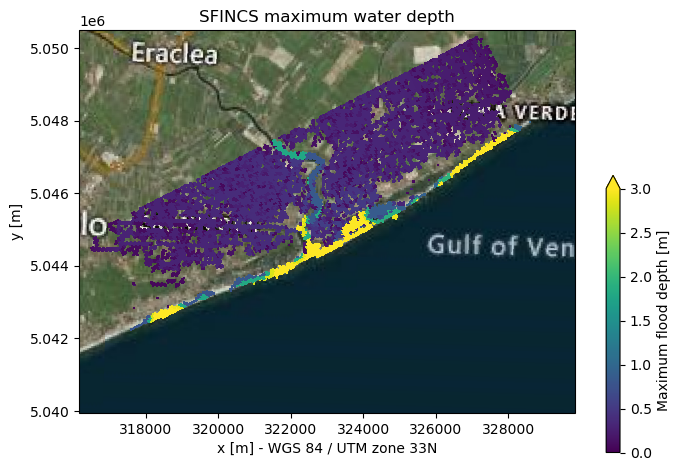

In [20]:
# Lastly, we create a basemap plot with hmax on top
fig, ax = mod.plot_basemap(
    fn_out=None,
    figsize=(8, 6),
    variable=da_hmax,
    plot_bounds=False,
    plot_geoms=False,
    bmap="sat",
    zoomlevel=11,
    vmin=0,
    vmax=3.0,
    cbar_kwargs={"shrink": 0.6, "anchor": (0, 0)},
)
ax.set_title(f"SFINCS maximum water depth")
# plt.savefig(join(mod.root, 'figs', 'hmax.png'), dpi=225, bbox_inches="tight")